In [2]:
!pip install transformers torch openai pillow

In [3]:
import torch
from PIL import Image, ImageDraw, ImageFont
from transformers import DetrImageProcessor, DetrForObjectDetection
from IPython.display import display
from getpass import getpass
from openai import OpenAI

# Get OpenAI key securely
api_key = getpass("Enter your OpenAI API key:")
client = OpenAI(api_key=api_key)

Enter your OpenAI API key:··········


Saving Screenshot 2025-10-20 at 3.10.56 PM.png to Screenshot 2025-10-20 at 3.10.56 PM.png


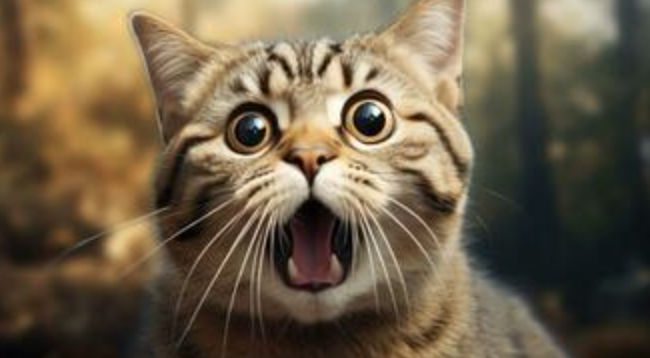

In [8]:
from google.colab import files
uploaded = files.upload()

# Load the uploaded image
img_path = list(uploaded.keys())[0]
image = Image.open(img_path).convert("RGB")
display(image)

In [9]:
print("Detecting objects...")

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

labels = results["labels"]
id2label = model.config.id2label
detected_objects = [id2label[int(label)] for label in labels]
unique_objects = list(set(detected_objects))[:5]

print("Detected objects:", unique_objects)

Detecting objects...


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Detected objects: ['cat']


In [10]:
prompt = f"Create a funny meme caption involving these objects: {', '.join(unique_objects)}."

response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": "You are a meme generator. Make it short and funny."},
        {"role": "user", "content": prompt}
    ]
)

caption = response.choices[0].message.content.strip()
print("Generated Caption:", caption)

Generated Caption: "Me: *tries to work* Cat: You mean pet me, right?" 🐱🖥️ #CatOwnerProblems


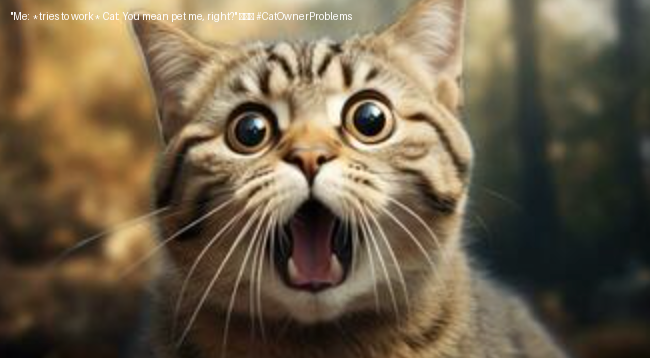

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
draw = ImageDraw.Draw(image)

try:
    font = ImageFont.truetype("arial.ttf", size=6000)
except:
    font = ImageFont.load_default()

# Word-wrap the caption
max_width = image.size[0] - 20
lines = []
words = caption.split()
line = ""

for word in words:
    test_line = line + word + " "
    bbox = font.getbbox(test_line)
    width = bbox[2] - bbox[0]
    if width <= max_width:
        line = test_line
    else:
        lines.append(line)
        line = word + " "
lines.append(line)

y_text = 10
for line in lines:
    draw.text((10, y_text), line, font=font, fill="white")
    y_text += 40

# Show and save the meme
display(image)
image.save("generated_meme.jpg")

from google.colab import files
files.download("generated_meme.jpg")
